# Characterization of positions and velocities

The purpose of this notebook is to characterize the positions and velocities of the galaxies in the inner protocluster. We wish to describe them by parameters so that we can easily generate positions and velocities in the splicing code at ../splice/generate_protocluster.py.

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from scipy.stats import rv_continuous, norm, halfnorm, kstest, shapiro, chisquare

In [2]:
# plot a probability-density histogram of x and display a Guassian fit, optionally fixing the mode
def plot_hist_fit(x, weights=None, randomvar=norm, fixed_mode=None, ax=None, xlabel=None, ylabel=None, title=None):
    
    # convert x and weights to numpy array, if not already
    x = np.asarray(x)
    if weights is not None: weights = np.asarray(weights)
    # remove any NaN values from x and weights
    if weights is not None:
        values_to_keep = ~(np.isnan(x) | np.isnan(weights))
        x = x[values_to_keep]
        weights = weights[values_to_keep]
    else:
        x = x[~np.isnan(x)]
    
    # if the axes was not specified, get the active axes (or create one)
    if ax is None:
        ax = plt.gca()
    
    # find best-fit distribution
    mean, std = randomvar.fit(
            x*weights/np.sum(weights) if weights is not None else x,
            floc=fixed_mode
        )
    
    # compute histogram of data
    hist, bin_edges = np.histogram(x,
                                   density=True if weights is not None else None,
                                   weights=weights)
    
    ## compute a Kolmogorov-Smirnov test to compute a p-value
    ## null hypothesis: the samples in x were drawn from the fit distribution
    #D, p = kstest(x*weights/np.sum(weights) if weights is not None else x, randomvar.cdf)
    
    # compute a Shapiro-Wilk test for normality
    # null hypothesis: the samples are drawn from some normal distribution
    _, p = shapiro(x*weights if weights is not None else x)
    
    # compute a Chi-squared test - this is not valid if weights is not None
    cdf_at_edges = randomvar.cdf(bin_edges, loc=mean, scale=std)
    chi2, p_chi2 = chisquare(hist, (cdf_at_edges[1:] - cdf_at_edges[:-1])*len(x))
    
    # plot the histogram
    bin_centres = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    ax.bar(x=bin_centres, height=hist, width=bin_widths, color='skyblue')
    
    # plot the Gaussian
    x_fit = np.linspace(np.min(x), np.max(x), num=1000)
    y_fit = len(x)*np.mean(bin_widths)*randomvar.pdf(x_fit, loc=mean, scale=std)
    ax.plot(x_fit, y_fit, color='crimson', linewidth=2)
    
    # add text with scale parameter (i.e. standard deviation) of the fit, chi2 and p-value
    ax.add_artist(AnchoredText('scale: {:.6g}\n$\chi^2$ = {:.3g}\np = {:.3f}\nS-W p = {:.3f}'.format(std, chi2, p_chi2, p), loc='upper right'))
    
    # labels and title
    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if title is not None: ax.set_title(title)

    ## set x limits
    #ax.set_xlim((bin_edges[0],bin_edges[-1]))
    

In [3]:
df = pandas.read_fwf('galaxy_masses_105.txt')

## Positions

We generate distances from the protocluster centre by assuming a uniform distribution.

We much choose the maximum value. It makes sense to choose a radius about 110 % the expected radius of the real protocluster. This is because:
* Galaxies will likely not be placed right at the edge.
* We might want some realizations that consider what might happen if the galaxies are more spread out along the line of sight than they are in other directions. (This corresponds to a radius larger than the expected radius.)


### Cutoff value

In [4]:
# maximum distance from centre - use 1.2 times the expected max speed for the observed protocluster
# note that df['r'] is already the expected distance from the centre in three dimensions
np.sqrt(df['x']**2 + df['y']**2).max()*1.1

109.28461029386854

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


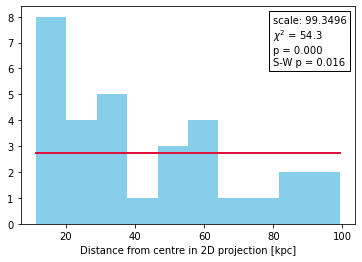

In [5]:
# here's a plot of what the distribution looks like

# random variable with    cdf(r) = r,    pdf(r) = 1
# this is the 1/sqrt probably distribution on a sphere of radius R,
# where pdf(r) is the probability density at radius r where 0 ≤ r ≤ R
class Sphere(rv_continuous):
    def _pdf(self, r):
        return np.where(r <= 1, 1, 0)
    def _cdf(self, r):
        return 0.5*np.where(r < 1, r, 1)
#         return 0.5*np.where(r < 1, np.sqrt(r), 1) + 0.5*halfnorm.cdf(r, loc=0, scale=0.48)
    def _fitstart(self, r):
        return (0, np.max(r))
    
sphere = Sphere(a=0)

plot_hist_fit(np.sqrt(df['x']**2+df['y']**2), randomvar=sphere, fixed_mode=0, xlabel='Distance from centre in 2D projection [kpc]')

plt.savefig('distance distribution.pdf')

## Velocities

We generate speeds from a normal distribution where we refuse to generate speeds that are greater than a cutoff value. We much choose both the cutoff value and the standard deviation of the distribution.

### Cutoff value

In [6]:
# maximum speed - use 1.2 times the expected max speed for the observed protocluster
np.abs(df['v'] - df['v'].mean()).max()*np.sqrt(3)*1.2
# the sqrt(3) factor accounts for df['v'] only being the line-of-sight velocity, not the total velocity
# (we assume the velocities are isotropic)

1681.8784321001394

### Standard deviation of the distribution

We fit a normal distribution to the data.

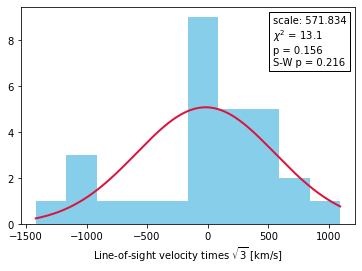

In [7]:
plot_hist_fit(df['v']*np.sqrt(3), xlabel='Line-of-sight velocity times $\sqrt{3}$ [km/s]')
plt.savefig('speed distribution.pdf')

---

# Extra

Just for fun: do other distributions work? And should we consider the moment of intertia (instead of distance-from-centre) or the line-of-sight momentum (instead of speed)?

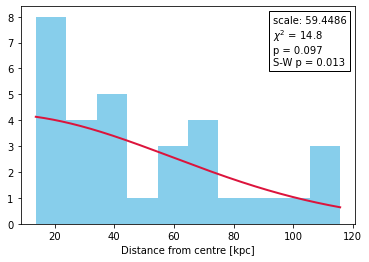

In [8]:
plot_hist_fit(df['r'], randomvar=halfnorm, fixed_mode=0, xlabel='Distance from centre [kpc]')

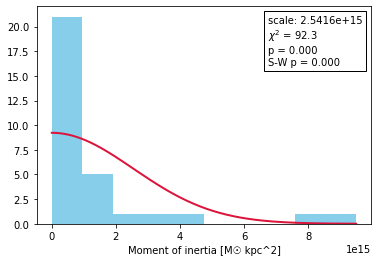

In [9]:
plot_hist_fit((df['M']*df['r']**2)*1e10, randomvar=halfnorm, fixed_mode=0, xlabel='Moment of inertia [M☉ kpc^2]')

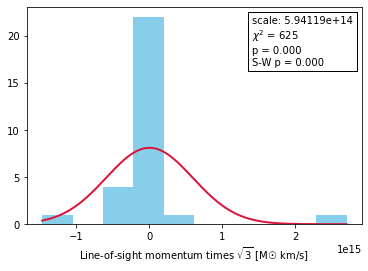

In [10]:
plot_hist_fit(df['v']*df['M']*np.sqrt(3)*1e10, xlabel='Line-of-sight momentum times $\sqrt{3}$ [M☉ km/s]')

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


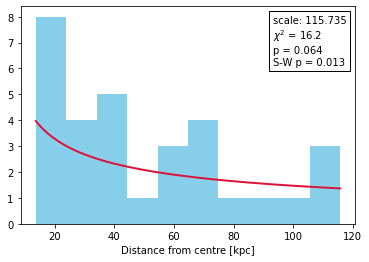

In [11]:
# random variable with    cdf(r) = sqrt(r/R),    pdf(r) = 1/(2sqrt(r/R))
# this is the 1/sqrt probably distribution on a sphere of radius R,
# where pdf(r) is the probability density at radius r where 0 ≤ r ≤ R
class Sphere(rv_continuous):
    def _pdf(self, r):
        return np.where(r < 1, 1/(2*np.sqrt(r)), 0)
    def _cdf(self, r):
        return np.where(r < 1, np.sqrt(r), 1)
    def _fitstart(self, r):
        return (0, np.max(r))
    
sphere = Sphere(a=0)

plot_hist_fit(df['r'], randomvar=sphere, fixed_mode=0, xlabel='Distance from centre [kpc]')

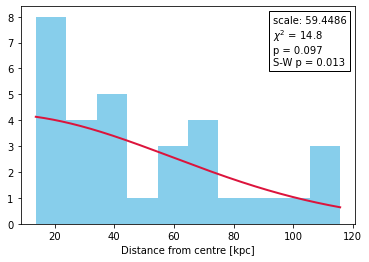

In [12]:
plot_hist_fit(df['r'], randomvar=halfnorm, fixed_mode=0, xlabel='Distance from centre [kpc]')

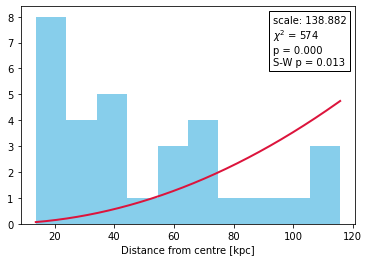

In [13]:
# random variable with    cdf(r) = (r/R)^3,    pdf(r) = 3r^2/(R^3)
# this is the uniform probably distribution on a sphere of radius R,
# where pdf(r) is the probability density at radius r where 0 ≤ r ≤ R
class Sphere(rv_continuous):
    def _pdf(self, r):
        return 3*(r**2)
    def _cdf(self, r):
        return r**3
    def fit(self, data, floc=None):
        return (0, 1.2*np.max(data)) # fit does not converge - this forces something at least
    
sphere = Sphere(a=0)

plot_hist_fit(df['r'], randomvar=sphere, fixed_mode=0, xlabel='Distance from centre [kpc]')

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


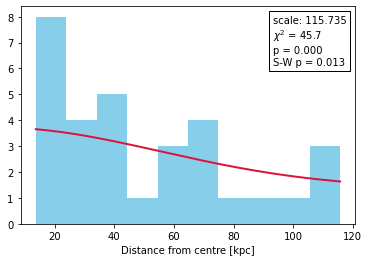

In [14]:
# random variable with    cdf(r) = r,    pdf(r) = 1
# this is the 1/sqrt probably distribution on a sphere of radius R,
# where pdf(r) is the probability density at radius r where 0 ≤ r ≤ R
class Sphere(rv_continuous):
    def _pdf(self, r):
        return np.where(r <= 1, 0.5 + 0.5*halfnorm.pdf(r, loc=0, scale=0.48)/halfnorm.cdf(1, loc=0, scale=0.48), 0)
    def _cdf(self, r):
        return 0.5*np.where(r < 1, 0.5*r + 0.5*halfnorm.cdf(r, loc=0, scale=0.48)/halfnorm.cdf(1, loc=0, scale=0.48), 1) 
    def _fitstart(self, r):
        return (0, np.max(r))
    
sphere = Sphere(a=0)

plot_hist_fit(df['r'], randomvar=sphere, fixed_mode=0, xlabel='Distance from centre [kpc]')